<a href="https://colab.research.google.com/github/BrunoMinetti/BootcampAluraDataScienceAplicada2021/blob/main/Bruno_Sanches_ProjetoModulo4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Análise dos casos de COVID-19, com perspectiva nas séries temporais e modelos preditivos**
---
Autor: Bruno Cesar Minetti Sanches<p>
GitHub: https://github.com/BrunoMinetti<p>
Linkedin: https://www.linkedin.com/in/brunocmsanches/<p>

---
###Breve currículo:<p> 
Gestor de Trânsito | Tecnólogo em Microeletrônica | Estudante de Análise e Desenvolvimento de Sistemas | Entusiasta da Ciência de Dados

##<strong><font color=#34C5F5>Orientações do projeto:</font></strong></p>
<p>Neste projeto do módulo 4 vamos trabalhar com a base de dados de casos de COVID-19, os impactos desta pandemia trouxe e ainda pode trazer consequências sem precedentes na sociedade moderna.</p>
<p>O foco deste projeto será analisar os casos de COVID-19 em uma perspectiva de Séries Temporais. Convidamos você a realizar uma análise dos dados, discutir suas estatísticas e desenvolver um modelo preditivo para prever o número de casos. Esse será os objetivos principais do projeto, mas sita-se livre para ir além do que estamos pedindo, o DATASUS tem muitas informações além dos número de casos e óbitos.</p>

- Os dados atualizados oficialmente pelo Ministério do Saúde você acessa por <a href='https://covid.saude.gov.br/'>este link</a>.

- Dados relacionados a SRAG para enriquecer sua análise você encontra <a href='https://opendatasus.saude.gov.br/dataset/bd-srag-2020'>neste link</a>

- Neste <a href='https://covid19br.github.io/'>link</a> você encontra várias outras informações relacionadas a COVID-19 para inspirar suas análises.

<p>Bora mergulhar que esse projeto será desafiador!</p>

## Bibliotecas:

In [1]:
#!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
from datetime import date
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
import pylab
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',FutureWarning)

In [3]:
URL_COVID = '/content/drive/MyDrive/Dados_COVID19/HIST_PAINEL_COVIDBR.csv'

##Dicionários e Listas:

In [4]:
'''
Aqui separo as colunas que considero úteis para a criação do data frame com os
dados da COVID19
'''
colunas_uteis = ['regiao',
                 'estado',
                 'municipio',
                 'nomeRegiaoSaude',
                 'data',
                 'semanaEpi',
                 'populacaoTCU2019',
                 'casosAcumulado',
                 'casosNovos',
                 'obitosAcumulado',
                 'obitosNovos',
                 'Recuperadosnovos',
                 'emAcompanhamentoNovos',
                 'interior/metropolitana']
'''
Criação do dicionário com dados particulares de cada estado, 
dispostos em ordem aleatóoria:
'''
estados_lista =  {
    0:['SP','São Paulo', 'Sudeste', 46289333],
    1:['MG','Minas Ger0ais', 'Sudeste', 21292666],
    2:['PR', 'Paraná', 'Sul', 11516840],
    3:['BA','Bahia', 'Nordeste', 14930634],
    4:['PE','Pernambuco', 'Nordeste', 9616621],
    5:['RJ', 'Rio de Janeiro', 'Sudeste', 17366189],
    6:['RS', 'Rio Grande do Sul', 'Sul', 11422973],
    7:['SC', 'Santa Catarina', 'Sul', 7252502],
    8:['CE', 'Ceará', 'Nordeste', 9187103],
    9:['GO', 'Goiás', 'Centro-Oeste', 7113540],
    10:['MA', 'Maranhão', 'Nordeste', 7114598],
    11:['PI', 'Piauí', 'Nordeste', 3281480],
    12:['PA', 'Pará', 'Norte', 8690745],
    13:['MT', 'Mato Grosso', 'Centro-Oeste', 3526220],
    14:['ES', 'Espírito Santo', 'Sudeste', 4064052],
    15:['PB', 'Paraíba', 'Nordeste', 4039277],
    16:['MS', 'Mato Grosso do Sul', 'Centro-Oeste', 2809394],
    17:['TO', 'Tocantins', 'Norte', 1590248],
    18:['SE', 'Sergipe', 'Nordeste', 2318822],
    19:['RN', 'Rio Grande do Norte', 'Nordeste', 3534165],
    20:['DF', 'Distrito Federal', 'Centro-Oeste', 3055149],
    21:['AM', 'Amazonas', 'Norte', 4207714],
    22:['RO', 'Rondônia', 'Norte', 1796460],
    23:['AL', 'Alagoas', 'Nordeste', 3351543], 
    24:['RR', 'Roraíma', 'Norte', 631181],
    25:['AP', 'Amapá', 'Norte', 861773],
    26:['AC', 'Acre', 'Norte', 894470]
}
'''
Não sei se será muito útil, mas é bem válido como estudo, 
construir o data frame a partir de um dicionário:
'''
estados_lista = pd.DataFrame.from_dict(data=estados_lista, orient='index', 
                                       columns=['uf','estado','regiao',
                                                'populacao'])
estados_lista.set_index('uf', inplace=True)
estados_lista = estados_lista.sort_values('populacao', ascending=False)
#Criei a lista de estados ordenados pela população extraindo direto do df.
estados = list(estados_lista.index)

indicadores_interessantes = [
                'data',
                'casosNovos',
                'casosAcumulado',
                'obitosNovos',
                'obitosAcumulado'
            ]

##Data Frame:

In [5]:
'''
Esse é o nosso Data Frame principal para o nosso estudo.
Casos de infecção e óbitos por COVID19 em todo território nacional:
'''
df_covid = pd.read_csv(URL_COVID, encoding='utf-8', sep=';',
                       usecols=colunas_uteis)
#df_covid.replace(np.nan,0, inplace=True) #Optei por manter os índices NaN.
df_covid['data'] = pd.to_datetime(df_covid['data']) #convertendo o campo data.
df_covid.head()

,regiao,estado,municipio,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,NaN,2020-02-25,9,210147125.0,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,1,0,0,NaN,NaN,NaN
2,Brasil,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,0,0,NaN,NaN,NaN
3,Brasil,NaN,NaN,NaN,2020-02-28,9,210147125.0,1,0,0,0,NaN,NaN,NaN
4,Brasil,NaN,NaN,NaN,2020-02-29,9,210147125.0,2,1,0,0,NaN,NaN,NaN


##Filtrando e manipulando dados:

####<strong><font color='#34C5F5'>Ponderações:</font></strong></p> 
<p>O filtro "populacaoTCU2019.notnull()" precisou ser incluido pois haviam muitas linhas repetidas o que poluíam os gráficos.<p>
Esse código será a base para uma futura função de plotagem de gráficos, onde irei inserir o estado e o indicador que desejo obter os gráficos, e terei o retorno automatizado.<p>
O filtro "municipio.isnull()" é porque nesse estudo quero buscar os dados separados pelos estados, não desejando obter essa capilaridade toda, que seria interessante, caso fôssemos plotar manchas de calor em um mapa. Fica anotado como um estudo futuro interessante.<p>

###Primeiras impresões do Data Frame:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


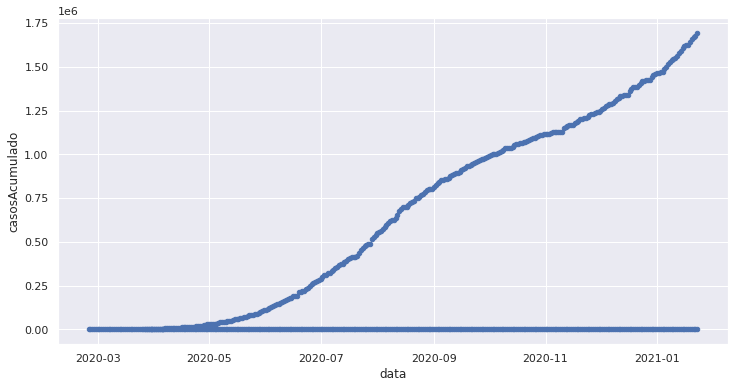

In [6]:
sns.set()
# Esse gráfico ruim pq tem muito resíduo.
df_covid.query('estado == "SP" and municipio.isnull()', engine='python')\
.plot(x='data',y='casosAcumulado',figsize=(12,6), kind='scatter');

####<strong><font color='#34C5F5'>Análise:</font></strong></p>
<p>Esse gráfico montei para justificar a utilização do filtro "populacaoTCU2019.notnull()" na minha *query* anterior.<p>
Podemos perceber uma linha reta abaixo da curva, isso é poluição no meu *data frame*.

####<strong><font color=red>Justificativa:</font></strong></p>
<p>Daqui para frente, como o objetivo do meu trabalho é estudar as séries temporais, estou fazendo os *slices* do meu *data frame* principal, selecionando apenas os dados interessantes para calcular as médias móveis, ARMA, ARIMA, e outros padrões temporais que me ajudarão a montar modelos preditivos.</p>
<p>Lembrando que quando montei o data frame para os dados da COVID19 eu já capturei apenas as colunas mais interessantes, prevendo os *slices* futuros, pois no caso de querer separar do *data frame* os dados nacionais, estaduais, regionais, ou municipais, as colunas de 'regiao', 'estado' e 'municipio', podem ser bastante úteis para filtrar, utilizando *queries*.</p>
<p>Esse data frame será utilizado para testar os métodos preditivos, incluindo novos dados e novas colunas.

###Conhecendo os dados e fazendo filtros para trabalhar melhor com eles:

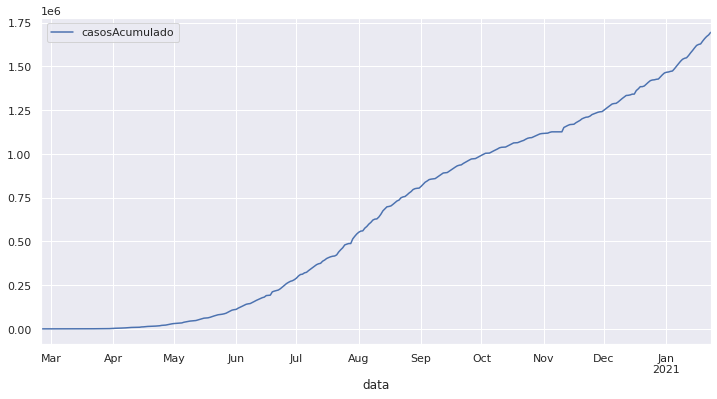

In [7]:
df_covid.query('estado == "SP" and municipio.isnull() and populacaoTCU2019.notnull()', engine='python')\
.plot(x='data',y='casosAcumulado',figsize=(12,6));

####<strong><font color='#34C5F5'>Análise:</font></strong></p>
<p>Podemos perceber no gráfico anterior, como temos uma evolução acendente crescente, Esse gráfico ainda não é o definitivo, mas já é possível perceber que os nossos filtros estão no caminho correto.<p>
Desejo plotar utilizando a biblioteca 'plotly', que irá me trazer gráficos mais bonitos, claros e interativos.<p>


In [8]:
def plot_covid_estado_indicador (uf, indicador):
    fig=go.Figure()
    df = df_covid.query('estado == @uf and municipio.isnull() and\
    populacaoTCU2019.notnull()',engine='python')[['data', indicador]]
    # Criando gráfico
    trace = go.Scatter(x = df['data'],
                    y = df[indicador],
                    mode = 'lines')
    # Armazenando gráfico em uma lista
    data = [trace]
    # Criando Layout
    layout = go.Layout(title=indicador+"_"+uf,
                    yaxis={'title':indicador},
                    xaxis={'title': 'Data'})
    # Criando figura que será exibida
    fig = go.Figure(data=data, layout=layout)
    # Exibindo figura/gráfico
    py.iplot(fig)
    
 
plot_covid_estado_indicador('SP','casosAcumulado')

In [9]:
plot_covid_estado_indicador('RJ','casosNovos')

In [10]:
def plot_bar_covid_estado_indicador (uf, indicador):
    df = df_covid.query('estado == @uf and municipio.isnull() and\
    populacaoTCU2019.notnull()',engine='python')[['data', indicador]]
    trace1 = go.Bar(x = df['data'],
                    y = df[indicador],
                    marker = {'color': '#6735FC'})
    data = [trace1]
    layout = go.Layout(title = indicador+'_'+uf,
                    xaxis = {'title': 'Data'},
                    yaxis = {'title': indicador},
                    barmode = 'stack')
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    

plot_bar_covid_estado_indicador('RJ','casosNovos')

In [11]:
def plot_linha_covid_estado_indicador (uf, indicador):
    df = df_covid.query('estado == @uf and municipio.isnull() and\
    populacaoTCU2019.notnull()',engine='python')[['data', indicador]]
    # Criando gráfico
    trace = go.Scatter(x =df['data'],
                    y = df[indicador],
                    mode = 'lines',
                    line = {'color': '#341f97'})
    # Armazenando gráfico em uma lista
    data = [trace]
    # Criando Layout
    layout = go.Layout(title=indicador+'_'+uf,
                    yaxis={'title': indicador},
                    xaxis={'title': 'Data'})
    # Criando figura que será exibida
    fig = go.Figure(data=data, layout=layout)
    # Exibindo figura/gráfico
    py.iplot(fig)
    

plot_linha_covid_estado_indicador('RJ','casosNovos')

In [12]:
# Esse gráfico serve para montar a estrutura quando formos montar a média móvel

def plot_bar_covid_estado_indicador (uf, indicador):
    df = df_covid.query('estado == @uf and municipio.isnull() and\
    populacaoTCU2019.notnull()',engine='python')[['data', indicador]]
    trace1 = go.Bar(x = df['data'],
                    y = df[indicador],
                    name=indicador+' - Gráfico de Barras',
                    marker = {'color': '#6735FC'})
    trace2 = go.Scatter(x =df['data'],
                y = df[indicador],
                mode = 'lines',
                name=indicador+' - Gráfico de Linha',
                line = {'color': '#FF2F0A'})
    data = [trace1,trace2]
    layout = go.Layout(title = indicador+'_'+uf,
                    xaxis = {'title': 'Data'},
                    yaxis = {'title': indicador},
                    barmode = 'stack')
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
    

plot_bar_covid_estado_indicador('RJ','casosNovos')

In [13]:
def plot_media_movel_covid_estado_indicador (uf, indicador):
    df = df_covid.query('estado == @uf and municipio.isnull() and\
    populacaoTCU2019.notnull()',engine='python')[['data', indicador]]
    df[f'mediaMovel{indicador}'] = df[indicador].rolling(14).mean()
    trace1 = go.Bar(x = df['data'],
                    y = df[indicador],
                    name=indicador,
                    marker = {'color': '#6735FC'})
    trace2 = go.Scatter(x =df['data'],
                y = df[f'mediaMovel{indicador}'],
                mode = 'lines',
                name='Média Móvel de '+indicador,
                line = {'color': '#FF2F0A'})
    data = [trace1,trace2]
    layout = go.Layout(title = 'Indicadores de '+indicador+'_'+uf+' com a média móvel',
                    xaxis = {'title': 'Data'},
                    yaxis = {'title': indicador},
                    barmode = 'stack')
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

### Comparativo entre estados

In [14]:
plot_media_movel_covid_estado_indicador('RJ','casosNovos')

In [15]:
plot_media_movel_covid_estado_indicador('SP','casosNovos')

####<p><strong><font color='#34C5F5'>Análise:</font></strong></p>
<p>Analisando os gráfico do número de casos novos no Estado do Rio de Janeiro e de São Paulo, percebemos que as médias móveis tem comportamentos bastante distintos, apesar da quantidade de casos em São Paulo ser muito maior, isso se justifica pela quantidade de pessoas, enquanto São Paulo tem 46289333 pessoas, o estado do Rio de Janeiro apresenta 17366189 pessoas, isso de acordo com a estimativa populacional do IBGE em 2020. </p>
<p>No gráfico de casos novos de SP aparentemente no período entre 06 e 10 de novembro o <a href='https://g1.globo.com/sp/sao-paulo/noticia/2020/12/16/estado-de-sp-relata-nova-falha-em-sistema-do-ministerio-da-saude-e-nao-divulga-dados-de-mortes-e-casos-por-covid-19-nesta-quarta.ghtml'>sistema apresentou falhas</a> e os dados ficaram acumulados nesses quatro dias, sendo apresentados todos juntos no dia 11, somando um pico enorme. </p>
<p>A média móvel é uma ferramenta muito útil para nos ajudar a visualizar séries temporais com comportamentos sazonais muito frequentes, e sistemas de informação com muitas falhas nos registros, pois suaviza os efeitos causados pelos picos e quedas, e nós auxilia a vizualizar  as tendências. </p>

In [16]:
def plot_media_movel_covid_nacional_indicador (indicador):
    df = df_covid.query('regiao == "Brasil" and populacaoTCU2019.notnull()\
     and municipio.isnull()', engine='python')[['data', indicador]]
    df[f'mediaMovel{indicador}'] = df[indicador].rolling(14).mean()
    trace1 = go.Bar(x = df['data'],
                    y = df[indicador],
                    name=indicador,
                    marker = {'color': '#6735FC'})
    trace2 = go.Scatter(x =df['data'],
                y = df[f'mediaMovel{indicador}'],
                mode = 'lines',
                name='Média Móvel de '+indicador,
                line = {'color': '#FF2F0A'})
    data = [trace1,trace2]
    layout = go.Layout(title = 'Indicadores de '+indicador+'_Brasil com a média móvel',
                    xaxis = {'title': 'Data'},
                    yaxis = {'title': indicador},
                    barmode = 'stack')
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

## Gráficos para análise de Casos Novos e Óbitos novos por COVID19 no terrítório nacional:

### Gráficos de barras diários com a média móvel com uma janela de 14 dias:

In [17]:
'''
indicador = str(input('digite um Indicador: '))

while indicador != 'sair':
    plot_media_movel_covid_nacional_indicador(indicador)
    indicador = str(input('digite um Indicador: ou "sair "'))
'''

plot_media_movel_covid_nacional_indicador('casosNovos')

####<p><strong><font color='#34C5F5'>Análise:</font></strong></p>
<p>Analisando o gráfico para os indicadores de casos novos em todo território nacional, percebemos que temos uma subida na quantidade de casos diários entre o começo de maio até 04 de agosto de 2020, e depois vemos uma queda entre agosto e 10 de novembro, quando a série volta a subir.</p>
<p>Imaginando uma tangente nas duas subidas que temos, entre maio e agosto e depois entre novembro e 22 de dezembro, o índice parece ser parecido, ou seja, parece ter a mesma taxa de crescimento. </p>
<p>Depois de 22 de dezembro, temos duas semanas de queda em todo o país, até 04 de janeiro, quando a média móvel dispara, ao maior de toda a série histórica.</p>
<p>Provavelmente, essa queda não tem relação com o comportamento da população, seja pela movimentação, pelo isolamento ou pela conscientização pelo uso dos equipamentos de segurança individuais, como máscaras e álcool gel, que efetivamente são constatados como importantes ferramentas para evitar a propagação do vírus, mas sim pela dificuldade dos órgãos oficiais em relatar e divulgar os casos novos no período das festas de fim de ano. </p>
<p>Até porque, o que vimos no fim de ano foram regiões de <a href='https://g1.globo.com/jornal-nacional/noticia/2020/12/05/a-vinte-dias-do-natal-sao-paulo-tem-sabado-de-aglomeracoes-no-comercio.ghtml'>comércio</a> <a href='https://g1.globo.com/sp/sao-paulo/noticia/2020/12/12/bras-tem-ruas-lotas-e-aglomeracao-comercios-de-bairro-sao-alternativas.ghtml'>popular</a>, <a href='https://www.cnnbrasil.com.br/nacional/2020/12/31/equipe-da-cnn-flagra-aglomeracao-em-ipanema-no-rio'>  praias</a> e <a href='https://www.terra.com.br/noticias/coronavirus/apesar-de-alta-da-covid-19-comercio-tem-aglomeracoes-em-sp,be53fc2e4ce036ef34c1d9c3a64fab24xg3d3pdo.html'>shoppings centers</a> completamente lotados, com muita aglomeração, o que pode justificar o grande crescimento visto após o período, até o fim da série, pois esses dados em atraso, passaram a ser notificados no começo do ano, além do que, as pessoas que se contaminaram no fim do ano, passaram a apresentar sintomas e procurar pela infraestrutura médica alguns dias depois, o que também acarreta nessa crescente.</p>


In [18]:
plot_media_movel_covid_nacional_indicador('obitosNovos')

<p><strong><font color='#34C5F5'>Análise:</font></strong> Analisando o gráfico para os indicadores de registros de óbitos para o território nacional, notamos que o crescimento como em abril, mas dispara numa crescente no dia 22, e assim segue até 05 de julho, quando a série para de subir, e se mantém num platô com um crescimento no número de registros bem menos acentuado. </p>
<p>No dia 25 de julho tivemos o pico da média móvel no número de casos, com 1070 mortes, depois desse pico, a série passou a cair, com quedas mais suaves, até o dia 10 de novembro, quando a média atingiu um valor de 348 mortes. </p>
<p>A partir daí até o final da série, vemos uma nova crescente, que pode indicar uma segunda onda do surto de COVID19, temos a informação de novas <a href='https://www.cnnbrasil.com.br/saude/2021/01/20/reino-unido-africa-e-brasil-novas-cepas-tem-semelhancas-nas-mutacoes'>cepas</a> circulando por todo o mundo com um grau de transmissibilidade ainda maior que as cepas iniciais, o que também pode justificar esse aumento no número de casos e mortes que vemos até o momento. </p>
<p>Um dado que pode ser interpretado como positivo, é que apesar da comunicação de casos estar em um patamar superior como nunca antes, os óbitos parecem não seguir a mesma crescente, e apesar da pandemia estar muito ativa, ela parece estar acometendo menos óbitos, levando em consideração que a curva entre 11 de novembro e 17 de janeiro tem uma inclinação bem menor do que a vista entre abril e junho. </p>


### Gráficos com os valores acumulados:

In [19]:
def plot_covid_nacional_indicador (indicador):
    fig=go.Figure()
    df = df_covid.query('regiao == "Brasil" and municipio.isnull() and\
    populacaoTCU2019.notnull()',engine='python')[['data', indicador]]
    # Criando gráfico
    trace = go.Scatter(x = df['data'],
                    y = df[indicador],
                    mode = 'lines')
    # Armazenando gráfico em uma lista
    data = [trace]
    # Criando Layout
    layout = go.Layout(title=f"Indicadores de {indicador} no Brasil",
                    yaxis={'title':indicador},
                    xaxis={'title': 'Data'})
    # Criando figura que será exibida
    fig = go.Figure(data=data, layout=layout)
    # Exibindo figura/gráfico
    py.iplot(fig)
    

plot_covid_nacional_indicador ('casosAcumulado')

In [20]:
plot_covid_nacional_indicador('obitosAcumulado')

####<p><strong><font color='#34C5F5'>Análise:</font></strong></p>
<p>Analisando o conjunto de gráficos acumulados para novos casos e óbitos, percebemos que as duas curvas vem em crescimento constante, e não demonstram em nenhum momento patamares, que poderia indicar que em determinado momento e nossos casos e óbitos estiveram controlados, ou seja, aparentemente nossas políticas públicas de controle à pandemia não surtiram efeito, ou não foram adequadas. </p>

### Histogramas com as semanas epidemiológicas:

In [21]:
def plot_covid_nacional_indicador_semanaEpi (indicador):
    df = df_covid.query('regiao == "Brasil" and populacaoTCU2019.notnull()\
     and municipio.isnull()', engine='python')[['data','semanaEpi', indicador]]
 
    df['aux'] = df['semanaEpi'].astype(str)+' de '+df['data'].dt.year.astype(str)
    bins = len(df['aux'].unique())

    x = df['aux']
    y = df[indicador]

    fig = go.Figure()

    fig.add_trace(go.Histogram(histfunc="sum", y=y, x=x, nbinsx=bins, 
                            text=indicador, ))
    fig.update_layout(
    barmode="overlay",
    bargap=0.1)

    fig.show()

plot_covid_nacional_indicador_semanaEpi ('casosNovos')

In [22]:
plot_covid_nacional_indicador_semanaEpi ('obitosNovos')

####<p><strong><font color='#34C5F5'>Análise:</font></strong></p>
<p>Analisando os histogramas com as semanas epidemiológicas para casos novos e óbitos por COVID, percebemos que o fator de sazonalidade semanal é mitigado, ficando mais claro acompanhar as tendências da epidemia, pois vimos nos gráficos anteriores, que existem um atraso na informação de casos e óbitos aos fins de semana.</p>
<p>Analisando os casos de infecção, assim como já percebemos com as médias móveis, é possível perceber duas ondas, sendo que a mais atual, parece estar em um crescimento, e o pico (semana 02 de 2021) já ultrapassou o pico mais alto da onda anterior (semana 30 de 2020).</p>
<p>Já na análise dos óbitos, o gráfico tem um formato diferente, é possível identificar as duas ondas, porém a segunda parece estar mais baixa.</p>
<p>Precisamos levar em conta dois fatores importantes nessa análise, na primeira onda, havia menos testagem disponível, os casos testados de acordo com a sintomatologia do paciente, sendo esperado um resultado positivo, na segunda onda, tendo maior disponibilidade para testagem, efetuou-se mais.</p>

### Cálculo para a taxa de letalidade:

In [23]:
###Cálculo do letalidade na primeira e na segunda onda
def taxa_letalidade (lista):
    obitos = df_covid[((df_covid.regiao =='Brasil')&(df_covid.semanaEpi.isin(lista)))][['obitosNovos']].values.sum()
    casos = df_covid[((df_covid.regiao =='Brasil')&(df_covid.semanaEpi.isin(lista)))][['casosNovos']].values.sum()
    return obitos *100 / casos

primeira_onda = [29,30,31]
segunda_onda = [1,2,3]

print('Taxa de letalidade:')
print('Primeira onda: %.2f'%taxa_letalidade(primeira_onda))
print('Segunda onda: %.2f'%taxa_letalidade(segunda_onda))

Taxa de letalidade:
Primeira onda: 2.55
Segunda onda: 1.88


####<p><strong><font color='#34C5F5'>Análise:</font></strong></p>
<p>As pessoas estão se cuidando menos, aderindo menos protócolos de segurança, e estão voltando a ter um comportamento próximo do usual, se aglomerando, e não tendo o mesmo asseio do começo da pandemia.</p>
<p>Taxa de letalidade*:</p>
<p>- Primeira onda:  2.55</p>
<p>- Segunda onda:  1.88</p>
<p>* Esse cálculo foi gentilmente ensinado pelo Vanessa Orsi.</p>
<p>A letalidade nessa segunda onda está menor, porque talvez agora, o sistema nacional de saúde esteja um pouco melhor preparado, com profissionais com mais experientes para tratar essa doença, mais bem equipados,tendo mais respiradores por exemplo, equipamentos insuficiente na primeira onda.</p>


##Estudo de decomposição das séries temporais de casos e óbitos novos de  COVID em território nacional

In [24]:
def decomposicao_nacional_adicao(indicador):
    decomposicao = seasonal_decompose(df_covid.query('regiao == "Brasil"', engine='python')[['data',indicador]][20:].set_index('data'), freq=12)
    pylab.rcParams['figure.figsize'] = (14, 9)
    decomposicao.plot()

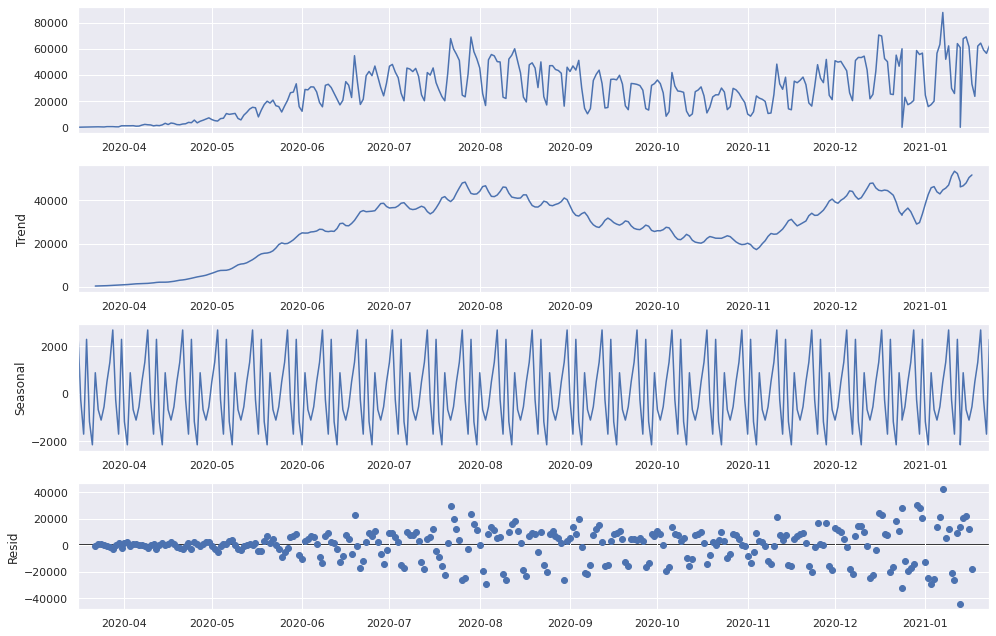

In [25]:
decomposicao_nacional_adicao('casosNovos');

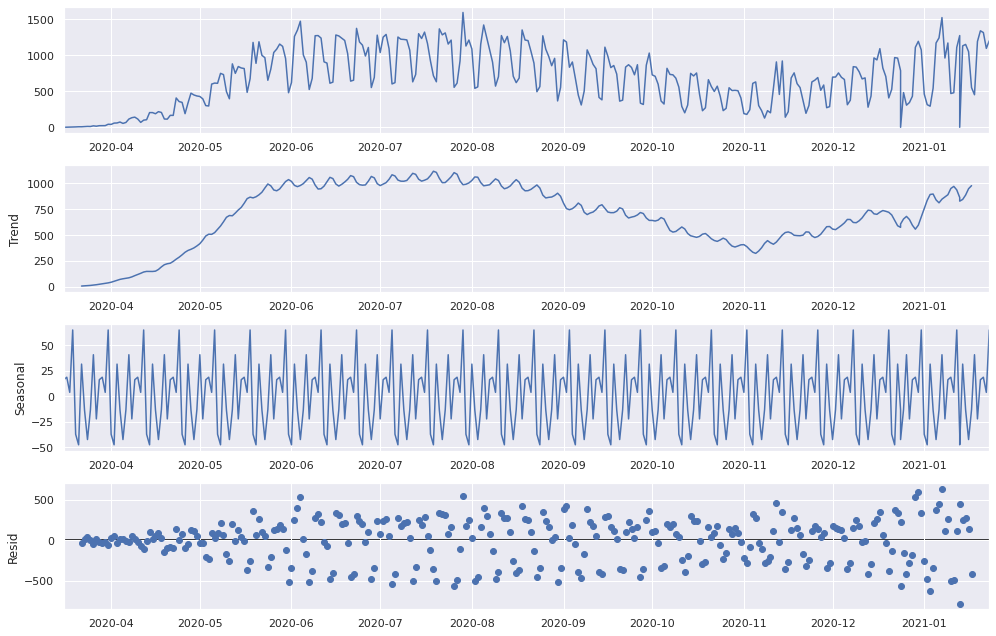

In [26]:
decomposicao_nacional_adicao('obitosNovos');

In [27]:
def decomposicao_nacional_multiplicacao(indicador):
    df = df_covid[(df_covid['regiao'] == 'Brasil')&(df_covid[indicador]>0)][['data',indicador]].set_index('data')
    decomposicao = seasonal_decompose(df, model='multiplicative', freq=12)
    pylab.rcParams['figure.figsize'] = (14, 9)
    decomposicao.plot()

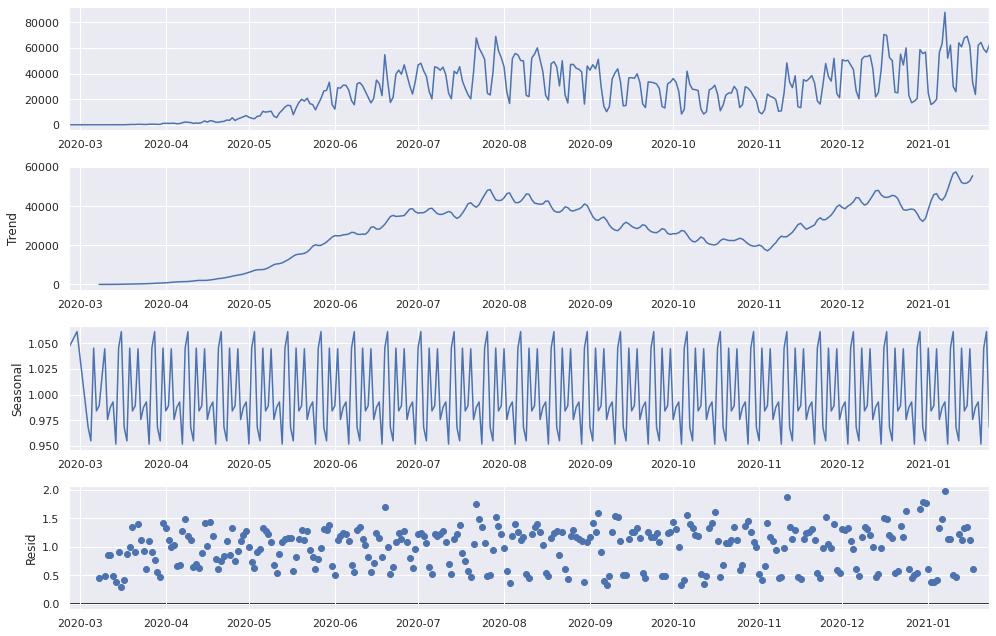

In [28]:
decomposicao_nacional_multiplicacao('casosNovos');

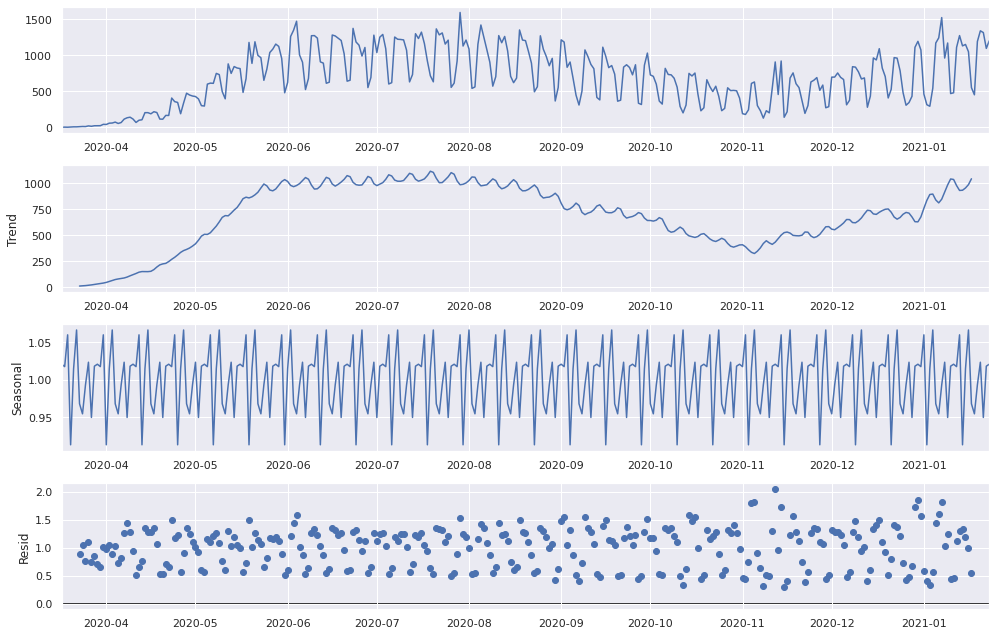

In [29]:
decomposicao_nacional_multiplicacao('obitosNovos');

<p><strong><font color='#34C5F5'>Análise:</font></strong></p>
<p>Fazendo a decomposição dos gráficos para casos novos e óbitos por COVID, podemos verificar pelo resíduo que os nossos gráficos seguem o modelo multiplicativo, pois em ambos o resíduo é menor.</p>
<p>Outro fator importante é que as séries não parecem ser estacionárias.<p>

## Verificando a Estacionariedade nos nossos dados:

### Utilizando recursos gráficos para fazer a comparação entre o valor observado, a média e o desvio padrão móveis:

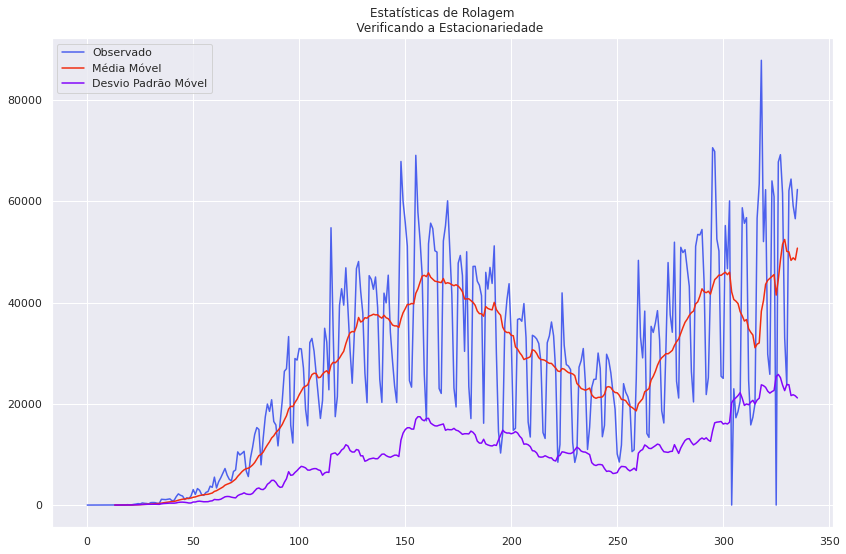

In [30]:
def plot_observado_mediamovel_desviomovel(indicador):
    mediamovel = df_covid[df_covid['regiao']=='Brasil'][[indicador]].rolling(14).mean()
    desviomovel = df_covid[df_covid['regiao']=='Brasil'][[indicador]].rolling(14).std()

    observado = plt.plot(df_covid[df_covid['regiao']=='Brasil'][[indicador]], color='#4C60ED', label='Observado')
    media = plt.plot(mediamovel, color='#F02D11', label='Média Móvel')
    desvio = plt.plot(desviomovel, color='#8305FA', label='Desvio Padrão Móvel')
    plt.legend(loc='best')
    plt.title('''Estatísticas de Rolagem
    Verificando a Estacionariedade''')
    plt.show(block=False)

plot_observado_mediamovel_desviomovel('casosNovos')

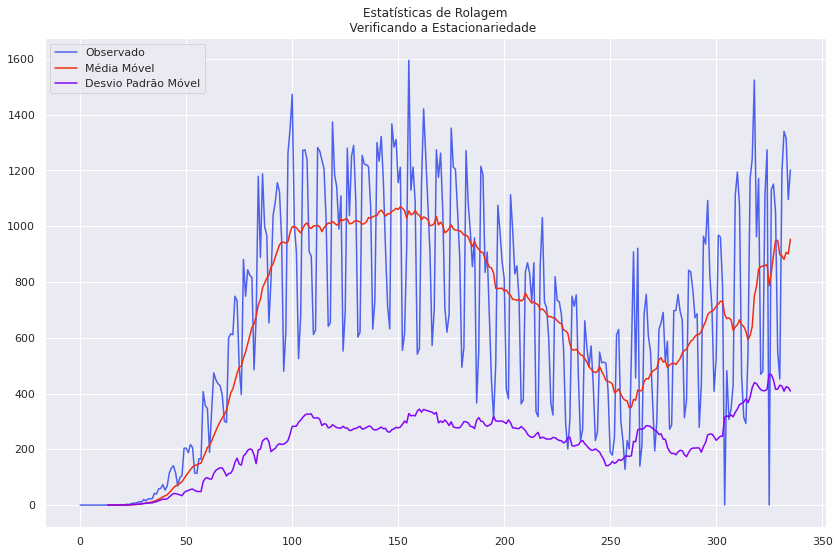

In [31]:
plot_observado_mediamovel_desviomovel('obitosNovos')

####<p><strong><font color='#34C5F5'>Análise:</font></strong></p>
<p>O que suspeitávamos analisando os gráficos de decomposição, podemos apurar como as <a href ='https://medium.com/@gisely.alves/s%C3%A9ries-temporais-parte-1-20fca5a6c7cd'>estatísticas de rolagem</a>, pois a média e a variância se alteram ao longo do tempo. A covariancia não vária, pois está relacionada com a frequência, que nos nossos dados é diária.</p>
* Agradeço por estudo a Gisely Alves por postar estudos tão ricos.

### Teste de hipóteses <a href='https://machinelearningmastery.com/time-series-data-stationary-python/'>Augmented Dickey-Fuller (ADCF)</a>:

Resumo:
- p-value > 0,05 - falha na hipótese nula, a série é não estacionária.
- p-value <= 0,05 - aceita a hipótese nula, a série é estacionária.

In [32]:
def teste_adfuller(indicador):
    serie = df_covid[df_covid['regiao']=='Brasil'][[indicador]].values
    resultado = adfuller(serie)
    return f'- O p-value é igual a {resultado[1]:.2f}  para o indicador de {indicador}.'

In [33]:
print(teste_adfuller('casosNovos'))
print(teste_adfuller('obitosNovos'))

- O p-value é igual a 0.73  para o indicador de casosNovos.
- O p-value é igual a 0.40  para o indicador de obitosNovos.


####<p><strong><font color='#34C5F5'>Análise:</font></strong></p>
<p>Fazendo o teste de Augmente Dickey-Fuller:</p>
<p>- O p-value é igual a 0.73 para o indicador de casosNovos.</p>
<p>- O p-value é igual a 0.40 para o indicador de obitosNovos.</p>
<p>O p-value é maior que 0,05, logo devemos rejeitar a hipoteses das duas séries serem estacionárias.</p>

### <a href='https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/'>Teste para Estacionariedade Kwiatkowski-Phillips-Schmidt-Shin (KPSS)</a>:

Resumo:
- p-value < 0,05 - falha na hipótese nula, a série é não estacionária.
- p-value >= 0,05 - aceita a hipótese nula, a série é estacionária.

In [34]:
def teste_kpss(indicador):
    resultados_kpss = kpss(df_covid[df_covid['regiao']=='Brasil'][[indicador]].values, nlags="auto")
    return (f'O p-value é igual a {(resultados_kpss[1]):.2f} para o indicador de {indicador}.')

In [35]:
print(teste_kpss('casosNovos'))
print(teste_kpss('obitosNovos'));

O p-value é igual a 0.01 para o indicador de casosNovos.
O p-value é igual a 0.01 para o indicador de obitosNovos.


####<p><strong><font color='#34C5F5'>Análise:</font></strong></p>
<p>Fazendo o teste para Estacionariedade Kwiatkowski-Phillips-Schmidt-Shin (KPSS):</p>
<p> - O p-value é igual a 0.01 para o indicador de casosNovos.</p>
<p> - O p-value é igual a 0.01 para o indicador de obitosNovos.</p>
<p>O p-value é menor do que 0,05, logo devemos rejeitar a hipoteses das duas séries serem estacionárias.</p>

###<p><strong><font color='#F08A0E'>Sintese até aqui:</font></strong></p>
<p>Rejeitamos a hipótese das séries de casos e óbitos novos por COVID serem estacionárias, com base nesses estudos, devemos então procurar o melhor modelo para tentarmos fazer nossas previsões de casos e óbitos.</p>
<p>Poderíamos transformar as nossas séries em estacionárias, contudo vou tentar fazer o meu modelo usando o que melhor se adequar às nossas séries.


### Estudo da autocorrelação e autocorreção parcial:

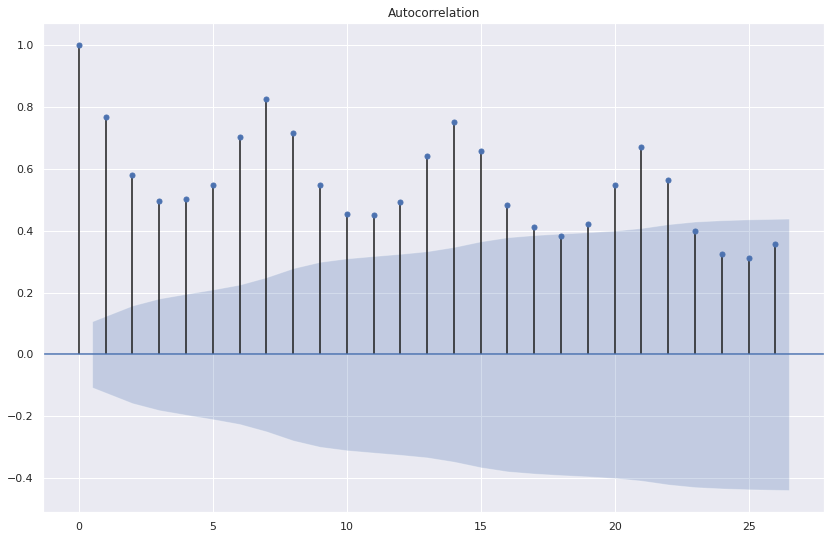

In [36]:
plot_acf(df_covid.query('regiao == "Brasil"', engine='python')[['obitosNovos']]);

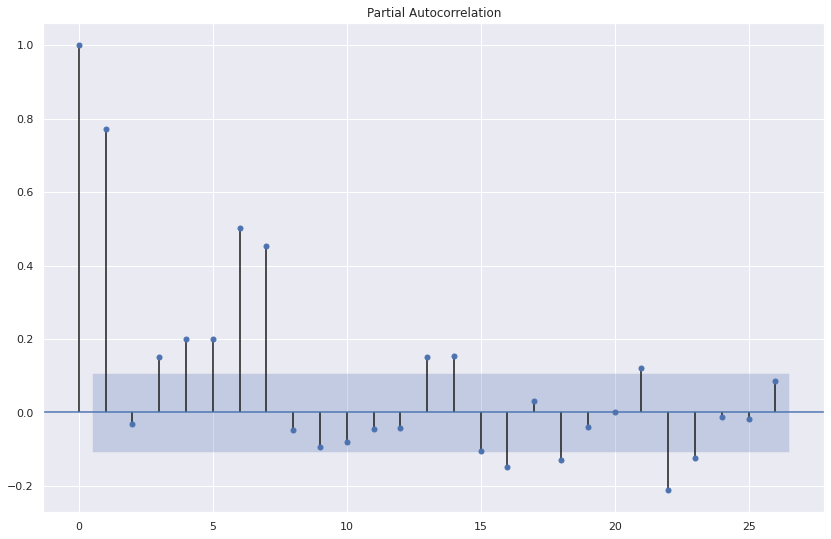

In [37]:
plot_pacf(df_covid.query('regiao == "Brasil"', engine='python')[['obitosNovos']]);

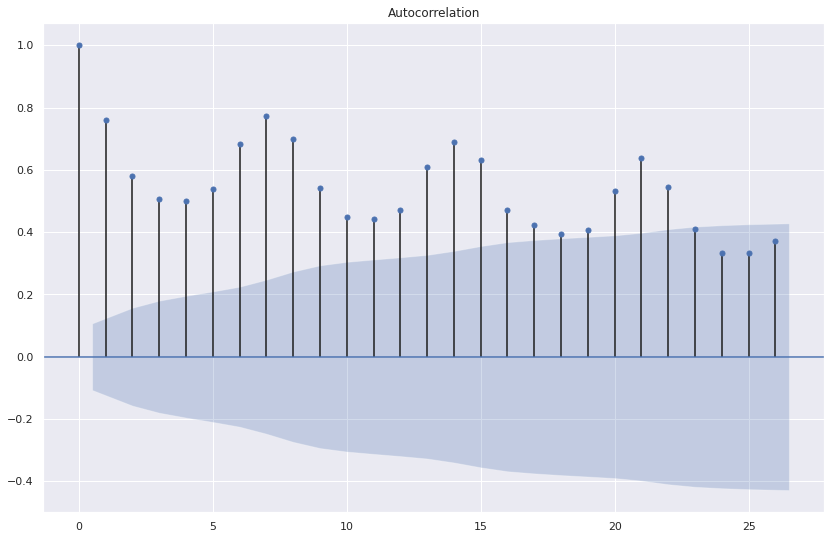

In [38]:
plot_acf(df_covid.query('regiao == "Brasil"', engine='python')[['casosNovos']]);

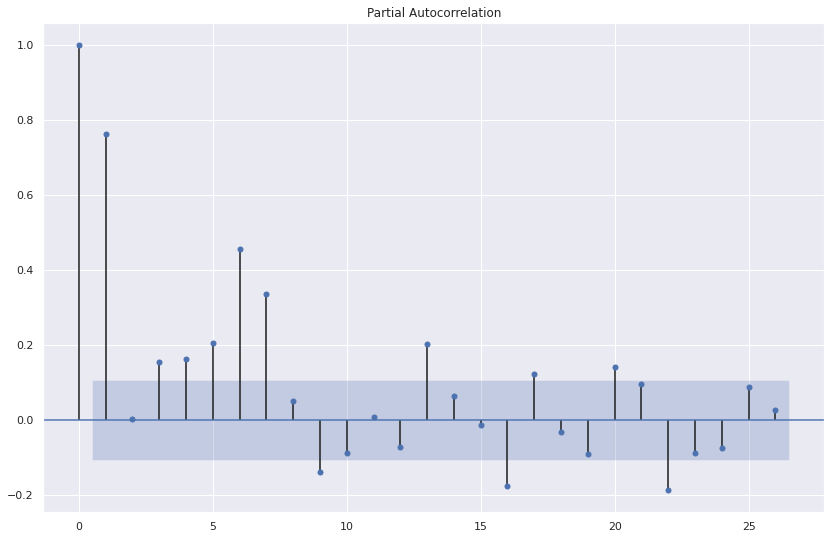

In [39]:
plot_pacf(df_covid.query('regiao == "Brasil"', engine='python')[['casosNovos']]);

## Previsões para novos casos e óbitos por COVID19 para todo o território nacional:

### Previsões com ARIMA:

In [40]:
#quantidade de dias para os modelos de teste e treino
n = 60

In [41]:
df_obitos = df_covid[(df_covid.regiao == 'Brasil')][['data','obitosNovos']]

treino_obitos = df_obitos[:-n]
teste_obitos = df_obitos[-n:]

In [42]:
df_casos = df_covid[(df_covid.regiao == 'Brasil')][['data','casosNovos']]

treino_casos = df_casos[:-n]
teste_casos = df_casos[-n:]

In [43]:
modelo_arima_casos = ARIMA(treino_casos['casosNovos'].values.astype('float32'), order=[11,1,3])
modelo_arima_treinado_casos = modelo_arima_casos.fit()
previsao_casos_arima = modelo_arima_treinado_casos.forecast(steps=n)[0]
teste_casos['previsao_arima'] = previsao_casos_arima

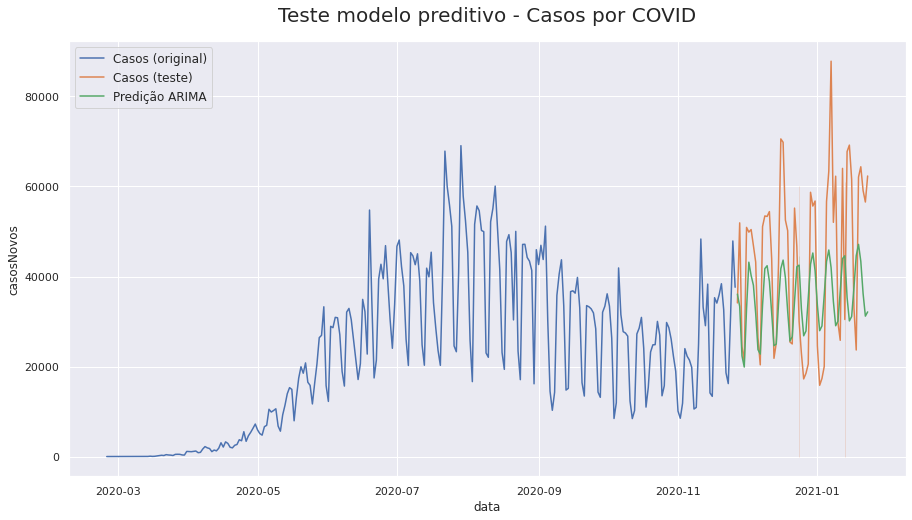

In [44]:
plt.figure(figsize=(15,8))
sns.lineplot(x='data', y='casosNovos', data=treino_casos)
sns.lineplot(x='data', y='casosNovos', data=teste_casos)
sns.lineplot(x='data', y='previsao_arima', data=teste_casos)
plt.title('Teste modelo preditivo - Casos por COVID', fontsize=20, pad=20)
plt.legend(['Casos (original)','Casos (teste)','Predição ARIMA'], fontsize=12)
plt.show()

In [45]:
modelo_arima_obitos = ARIMA(treino_obitos['obitosNovos'].values.astype('float32'), order=[13,1,3])
modelo_arima_treinado_obitos = modelo_arima_obitos.fit()
previsao_obitos_arima = modelo_arima_treinado_obitos.forecast(steps=n)[0]
teste_obitos['previsao_arima'] = previsao_obitos_arima

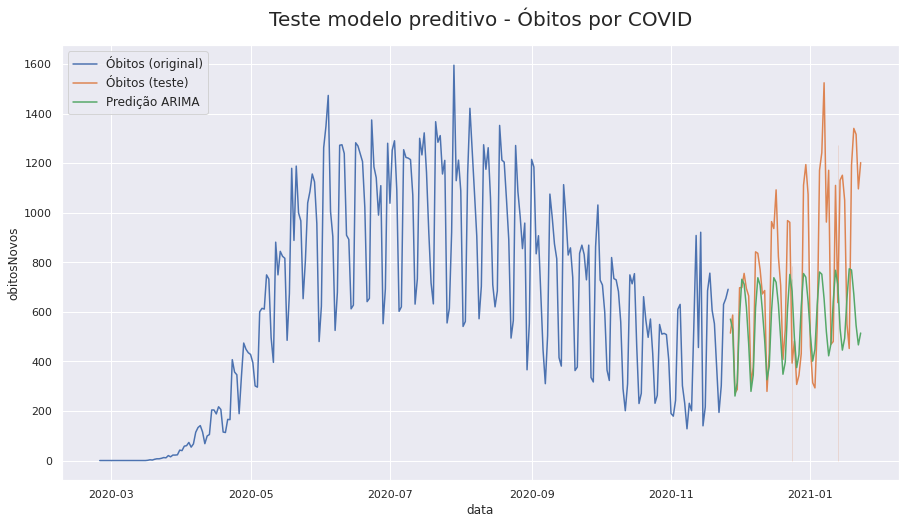

In [46]:
plt.figure(figsize=(15,8))
sns.lineplot(x='data', y='obitosNovos', data=treino_obitos)
sns.lineplot(x='data', y='obitosNovos', data=teste_obitos)
sns.lineplot(x='data', y='previsao_arima', data=teste_obitos)
plt.title('Teste modelo preditivo - Óbitos por COVID', fontsize=20, pad=20)
plt.legend(['Óbitos (original)','Óbitos (teste)','Predição ARIMA'], fontsize=12)
plt.show()

####<p><strong><font color='#34C5F5'>Análise:</font></strong></p>
<p>As previsões para os casos e os óbitos tiveram um comportamendo parecido, no modelo ARIMA.</p>`


### Previsões com AUTOARIMA:

In [47]:
modelo_autoarima_casos = auto_arima(treino_casos['casosNovos'].values, error_action='ignore', trace=True, seasonal=True, m=31, D=1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[31]             : AIC=inf, Time=14.75 sec
 ARIMA(0,1,0)(0,1,0)[31]             : AIC=5409.450, Time=0.14 sec
 ARIMA(1,1,0)(1,1,0)[31]             : AIC=5310.391, Time=1.62 sec
 ARIMA(0,1,1)(0,1,1)[31]             : AIC=inf, Time=1.68 sec
 ARIMA(1,1,0)(0,1,0)[31]             : AIC=5399.348, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[31]             : AIC=5306.286, Time=5.01 sec
 ARIMA(1,1,0)(2,1,1)[31]             : AIC=inf, Time=24.71 sec
 ARIMA(1,1,0)(1,1,1)[31]             : AIC=5297.438, Time=2.72 sec
 ARIMA(1,1,0)(0,1,1)[31]             : AIC=inf, Time=5.07 sec
 ARIMA(1,1,0)(1,1,2)[31]             : AIC=5297.091, Time=7.72 sec
 ARIMA(1,1,0)(0,1,2)[31]             : AIC=5300.310, Time=5.29 sec
 ARIMA(1,1,0)(2,1,2)[31]             : AIC=inf, Time=13.71 sec
 ARIMA(0,1,0)(1,1,2)[31]             : AIC=inf, Time=6.85 sec
 ARIMA(2,1,0)(1,1,2)[31]             : AIC=5262.150, Time=10.02 sec
 ARIMA(2,1,0)(0,1,2)[31]             : AIC=52

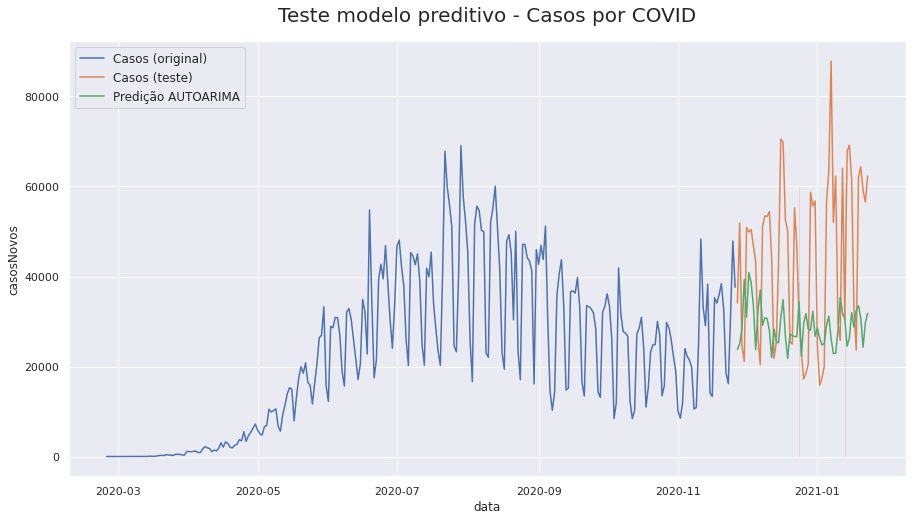

In [48]:
previsao_casos_autoarima = modelo_autoarima_casos.predict(n_periods=n)
teste_casos['previsao_autoarima'] = previsao_casos_autoarima

plt.figure(figsize=(15,8))
sns.lineplot(x='data', y='casosNovos', data=treino_casos)
sns.lineplot(x='data', y='casosNovos', data=teste_casos)
sns.lineplot(x='data', y='previsao_autoarima', data=teste_casos)
plt.title('Teste modelo preditivo - Casos por COVID', fontsize=20, pad=20)
plt.legend(['Casos (original)','Casos (teste)','Predição AUTOARIMA'], fontsize=12)
plt.show()

In [49]:
modelo_autoarima_obitos = auto_arima(treino_obitos['obitosNovos'].values, error_action='ignore', trace=True, seasonal=True, m=31, D=1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[31]             : AIC=inf, Time=18.06 sec
 ARIMA(0,1,0)(0,1,0)[31]             : AIC=3613.130, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[31]             : AIC=3527.685, Time=1.93 sec
 ARIMA(0,1,1)(0,1,1)[31]             : AIC=inf, Time=5.44 sec
 ARIMA(1,1,0)(0,1,0)[31]             : AIC=3608.405, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[31]             : AIC=3513.381, Time=6.39 sec
 ARIMA(1,1,0)(2,1,1)[31]             : AIC=inf, Time=29.24 sec
 ARIMA(1,1,0)(1,1,1)[31]             : AIC=inf, Time=9.24 sec
 ARIMA(0,1,0)(2,1,0)[31]             : AIC=3514.210, Time=3.91 sec
 ARIMA(2,1,0)(2,1,0)[31]             : AIC=3474.200, Time=8.03 sec
 ARIMA(2,1,0)(1,1,0)[31]             : AIC=3508.352, Time=3.11 sec
 ARIMA(2,1,0)(2,1,1)[31]             : AIC=inf, Time=31.46 sec
 ARIMA(2,1,0)(1,1,1)[31]             : AIC=inf, Time=13.28 sec
 ARIMA(3,1,0)(2,1,0)[31]             : AIC=3465.770, Time=12.47 sec
 ARIMA(3,1,0)(1,1,0)[31]             : AIC=3

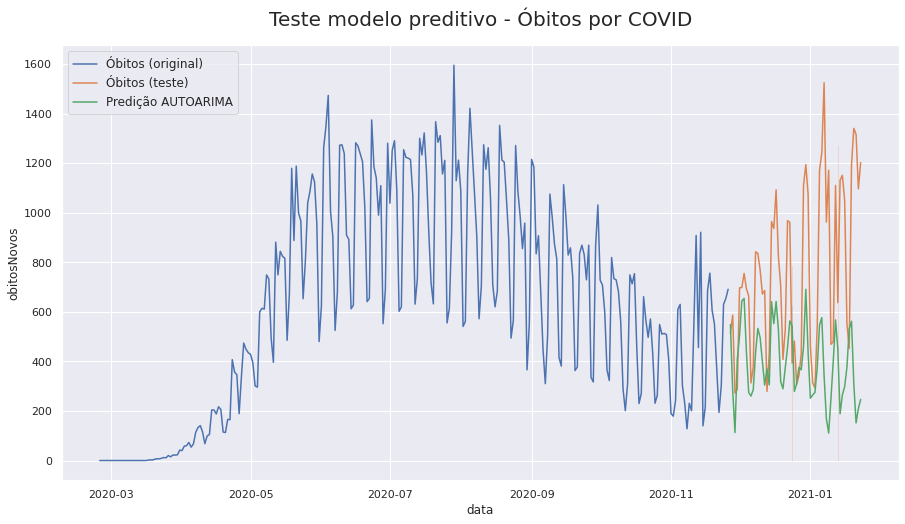

In [50]:
previsao_obitos_autoarima = modelo_autoarima_obitos.predict(n_periods=n)
teste_obitos['previsao_autoarima'] = previsao_obitos_autoarima

plt.figure(figsize=(15,8))
sns.lineplot(x='data', y='obitosNovos', data=treino_obitos)
sns.lineplot(x='data', y='obitosNovos', data=teste_obitos)
sns.lineplot(x='data', y='previsao_autoarima', data=teste_obitos)
plt.title('Teste modelo preditivo - Óbitos por COVID', fontsize=20, pad=20)
plt.legend(['Óbitos (original)','Óbitos (teste)','Predição AUTOARIMA'], fontsize=12)
plt.show()

####<p><strong><font color='#34C5F5'>Análise:</font></strong></p>
As previsões para os casos e os óbitos tiveram um comportamendo parecido, no modelo AUTOARIMA. O modelo ARIMA aparenta ter performado sutilmente melhor.</p>

### Previsões com Prophet:

In [51]:
modelo_profeta_casos = Prophet()

mapa = {'data':'ds','casosNovos':'y'}

treino_casos_profeta = treino_casos[['data','casosNovos']].rename(mapa, axis=1)
modelo_profeta_casos_treinado = modelo_profeta_casos.fit(treino_casos_profeta)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
futuro_casos = modelo_profeta_casos_treinado.make_future_dataframe(periods=90, freq='D')
futuro_casos

,ds
0,2020-02-25
1,2020-02-26
2,2020-02-27
3,2020-02-28
4,2020-02-29
...,...
361,2021-02-20
362,2021-02-21
363,2021-02-22
364,2021-02-23


In [53]:
resultado_profeta_casos = modelo_profeta_casos_treinado.predict(futuro_casos)
resultado_profeta_casos

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-25,-7576.660449,-14883.951042,3894.961201,-7576.660449,-7576.660449,2072.370169,2072.370169,2072.370169,2072.370169,2072.370169,2072.370169,0.0,0.0,0.0,-5504.290280
1,2020-02-26,-7284.088196,-10781.033145,8447.772783,-7284.088196,-7284.088196,6372.932618,6372.932618,6372.932618,6372.932618,6372.932618,6372.932618,0.0,0.0,0.0,-911.155578
2,2020-02-27,-6991.515942,-12177.507783,7903.900193,-6991.515942,-6991.515942,5010.052208,5010.052208,5010.052208,5010.052208,5010.052208,5010.052208,0.0,0.0,0.0,-1981.463734
3,2020-02-28,-6698.943688,-12059.864679,7375.201038,-6698.943688,-6698.943688,4512.326267,4512.326267,4512.326267,4512.326267,4512.326267,4512.326267,0.0,0.0,0.0,-2186.617421
4,2020-02-29,-6406.371435,-14390.423263,4244.275025,-6406.371435,-6406.371435,1483.597739,1483.597739,1483.597739,1483.597739,1483.597739,1483.597739,0.0,0.0,0.0,-4922.773696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2021-02-20,8362.772256,-1237.383568,21163.457525,3257.497380,13566.791258,1483.597739,1483.597739,1483.597739,1483.597739,1483.597739,1483.597739,0.0,0.0,0.0,9846.369995
362,2021-02-21,8209.755155,-12480.905557,10286.482279,3042.479934,13459.808495,-9487.783033,-9487.783033,-9487.783033,-9487.783033,-9487.783033,-9487.783033,0.0,0.0,0.0,-1278.027878
363,2021-02-22,8056.738054,-12899.007729,9716.098486,2778.542851,13386.467129,-9963.495969,-9963.495969,-9963.495969,-9963.495969,-9963.495969,-9963.495969,0.0,0.0,0.0,-1906.757915
364,2021-02-23,7903.720953,-713.464942,21853.615963,2495.340518,13328.033955,2072.370169,2072.370169,2072.370169,2072.370169,2072.370169,2072.370169,0.0,0.0,0.0,9976.091122


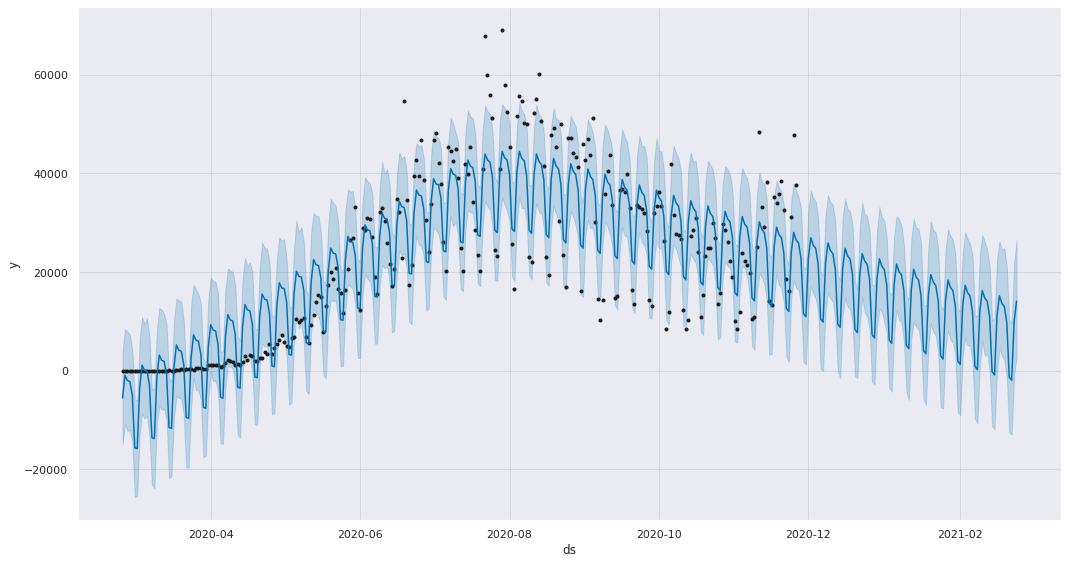

In [54]:
modelo_profeta_casos_treinado.plot(resultado_profeta_casos, figsize=(15,8));

In [55]:
modelo_profeta_obitos = Prophet()

mapa = {'data':'ds','obitosNovos':'y'}

treino_obitos_profeta = treino_obitos[['data','obitosNovos']].rename(mapa, axis=1)
modelo_profeta_obitos_treinado = modelo_profeta_obitos.fit(treino_obitos_profeta)
futuro_obitos = modelo_profeta_obitos_treinado.make_future_dataframe(periods=90, freq='D')
resultado_profeta_obitos = modelo_profeta_obitos_treinado.predict(futuro_casos)
resultado_profeta_obitos

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-25,-221.348806,-289.197647,122.010597,-221.348806,-221.348806,133.014204,133.014204,133.014204,133.014204,133.014204,133.014204,0.0,0.0,0.0,-88.334602
1,2020-02-26,-210.209650,-258.291819,169.295639,-210.209650,-210.209650,162.136421,162.136421,162.136421,162.136421,162.136421,162.136421,0.0,0.0,0.0,-48.073228
2,2020-02-27,-199.070494,-278.208429,153.221394,-199.070494,-199.070494,150.377607,150.377607,150.377607,150.377607,150.377607,150.377607,0.0,0.0,0.0,-48.692887
3,2020-02-28,-187.931338,-327.744418,87.127162,-187.931338,-187.931338,69.489260,69.489260,69.489260,69.489260,69.489260,69.489260,0.0,0.0,0.0,-118.442079
4,2020-02-29,-176.792183,-407.123235,35.136329,-176.792183,-176.792183,2.246052,2.246052,2.246052,2.246052,2.246052,2.246052,0.0,0.0,0.0,-174.546130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2021-02-20,-85.671711,-359.099114,183.992488,-249.979274,63.355959,2.246052,2.246052,2.246052,2.246052,2.246052,2.246052,0.0,0.0,0.0,-83.425659
362,2021-02-21,-90.928273,-639.162970,-102.242150,-257.476521,60.445436,-276.612967,-276.612967,-276.612967,-276.612967,-276.612967,-276.612967,0.0,0.0,0.0,-367.541239
363,2021-02-22,-96.184835,-614.314849,-66.927210,-264.973767,58.062321,-240.650578,-240.650578,-240.650578,-240.650578,-240.650578,-240.650578,0.0,0.0,0.0,-336.835413
364,2021-02-23,-101.441396,-254.612256,302.270363,-272.695194,56.445299,133.014204,133.014204,133.014204,133.014204,133.014204,133.014204,0.0,0.0,0.0,31.572807


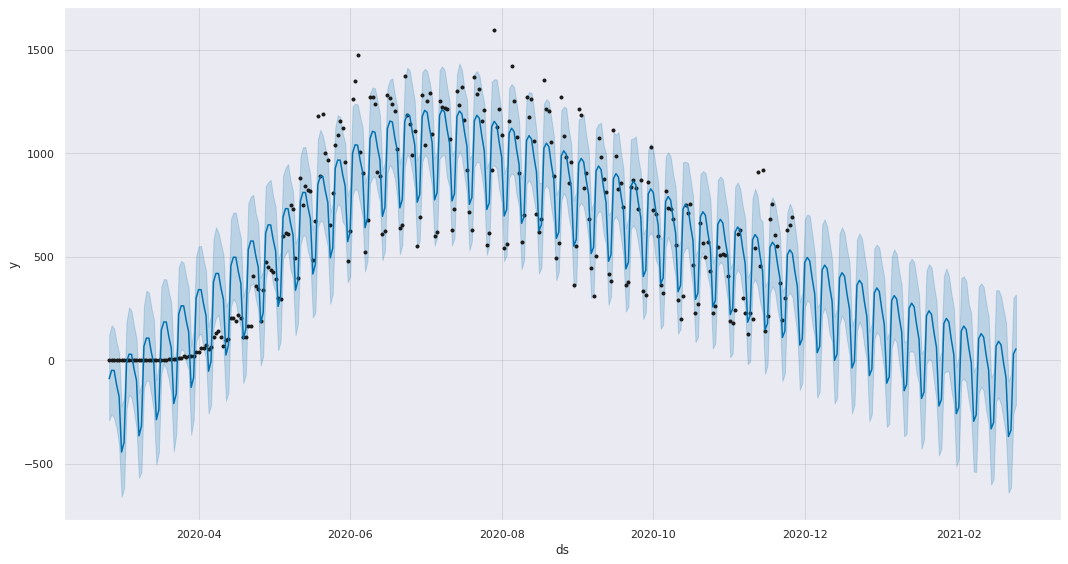

In [56]:
modelo_profeta_obitos_treinado.plot(resultado_profeta_obitos, figsize=(15,8));

####<p><strong><font color='#34C5F5'>Análise:</font></strong> </p>
<p>As previsões para os casos e os óbitos tiveram um comportamendo parecido, no modelo Prophet. Contudo as previsões não parecem muito assertivas, pelo gráfico podemos entender que nos proximos meses a Pandemia estaria acabando, o que não parece fazer sentido.</p>

### Previsões utilizando SARIMA:

In [57]:
modelo_sarima_casos = sm.tsa.statespace.SARIMAX(treino_casos['casosNovos'].values, order= (5,1,2), seasonal_order= (2,1,2,31))

modelo_sarima_casos_treinado = modelo_sarima_casos.fit()
valores = modelo_sarima_casos_treinado.forecast(steps=60)
valores = valores.round().astype(int)
teste_casos['previsao_sarima'] = valores

In [58]:
teste_casos

,data,casosNovos,previsao_arima,previsao_autoarima,previsao_sarima
276,2020-11-27,34130,36080.801749,23824.269578,34861
277,2020-11-28,51922,33355.515791,25064.811101,33489
278,2020-11-29,24468,22361.433651,28478.406735,21291
279,2020-11-30,21138,19883.215240,39362.936723,19389
280,2020-12-01,50909,32827.000293,30995.692317,28129
281,2020-12-02,49863,43183.755960,40908.476792,44896
282,2020-12-03,50434,40235.101355,38680.102559,40783
283,2020-12-04,46884,38071.471687,33509.942370,33565
284,2020-12-05,43209,31834.317378,23744.501774,26892
285,2020-12-06,26363,23751.223807,32343.974121,22590


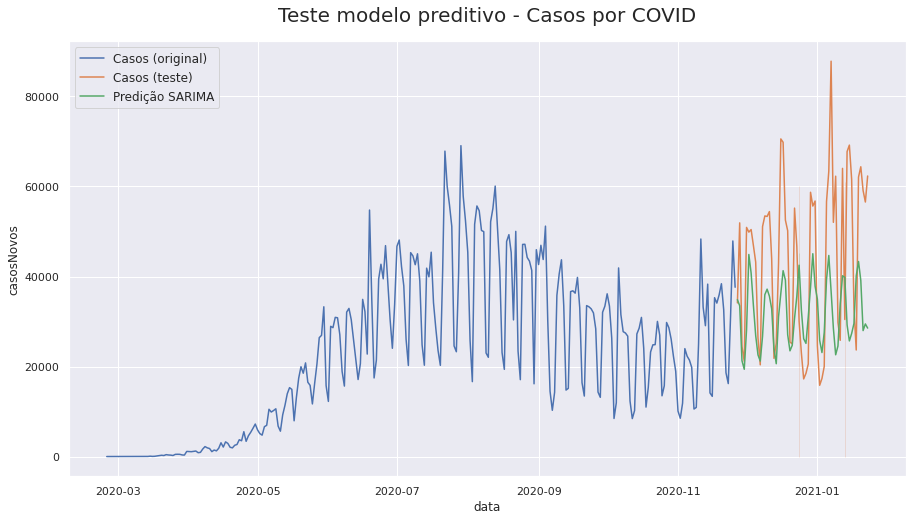

In [59]:
plt.figure(figsize=(15,8))
sns.lineplot(x='data', y='casosNovos', data=treino_casos)
sns.lineplot(x='data', y='casosNovos', data=teste_casos)
sns.lineplot(x='data', y='previsao_sarima', data=teste_casos)
plt.title('Teste modelo preditivo - Casos por COVID', fontsize=20, pad=20)
plt.legend(['Casos (original)','Casos (teste)','Predição SARIMA'], fontsize=12)
plt.show()

In [60]:
modelo_autoarima_casos.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  276
Model:             SARIMAX(4, 1, 0)x(1, 1, [1], 31)   Log Likelihood               -2600.353
Date:                              Tue, 26 Jan 2021   AIC                           5214.707
Time:                                      17:49:32   BIC                           5239.187
Sample:                                           0   HQIC                          5224.566
                                              - 276                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2479      0.084     -2.948      0.003      -0.413      -0.083
ar.L2         -0.5400      0.094     -5.763      0.000      -0.724      -0.356
ar.L3         -0.1308      0.108     -1.206      0.228      -0.343       0.082
ar.L4         -0.1416      0.108     -1.305      0.192      -0.354       0.071
ar.S.L31      -0.4575      0.117     -3.903      0.000      -0.687      -0.228
ma.S.L31      -0.7184      0.113     -6.385      0.000      -0.939      -0.498
sigma2      1.387e+08   2.85e-10   4.86e+17      0.000    1.39e+08    1.39e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.56   Jarque-Bera (JB):                 6.67
Prob(Q):                              0.21   Prob(JB):                         0.04
Heteroskedasticity (H):               6.77   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.22e+34. Standard errors may be unstable.
"""

In [61]:
modelo_autoarima_obitos.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  276
Model:             SARIMAX(5, 1, 2)x(2, 1, [1], 31)   Log Likelihood               -1601.124
Date:                              Tue, 26 Jan 2021   AIC                           3224.249
Time:                                      17:49:32   BIC                           3262.718
Sample:                                           0   HQIC                          3239.742
                                              - 276                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1605      0.100      1.608      0.108      -0.035       0.356
ar.L2         -0.6899      0.079     -8.719      0.000      -0.845      -0.535
ar.L3         -0.3360      0.101     -3.339      0.001      -0.533      -0.139
ar.L4         -0.3479      0.079     -4.393      0.000      -0.503      -0.193
ar.L5         -0.5422      0.100     -5.448      0.000      -0.737      -0.347
ma.L1         -0.9764      0.093    -10.510      0.000      -1.158      -0.794
ma.L2          0.6721      0.088      7.666      0.000       0.500       0.844
ar.S.L31      -0.1106      0.262     -0.421      0.674      -0.625       0.404
ar.S.L62      -0.2224      0.199     -1.117      0.264      -0.613       0.168
ma.S.L31      -0.5858      0.314     -1.867      0.062      -1.201       0.029
sigma2      3.718e+04   4747.381      7.831      0.000    2.79e+04    4.65e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                49.24
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                             0.57
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
modelo_sarima_obitos = sm.tsa.statespace.SARIMAX(treino_obitos['obitosNovos'].values, order= (5,1,2), seasonal_order= (2,1,2,31))

modelo_sarima_obitos_treinado = modelo_sarima_obitos.fit()
valores_obitos = modelo_sarima_obitos_treinado.forecast(steps=60)
valores_obitos = valores_obitos.round().astype(int)
teste_obitos['previsao_sarima'] = valores_obitos

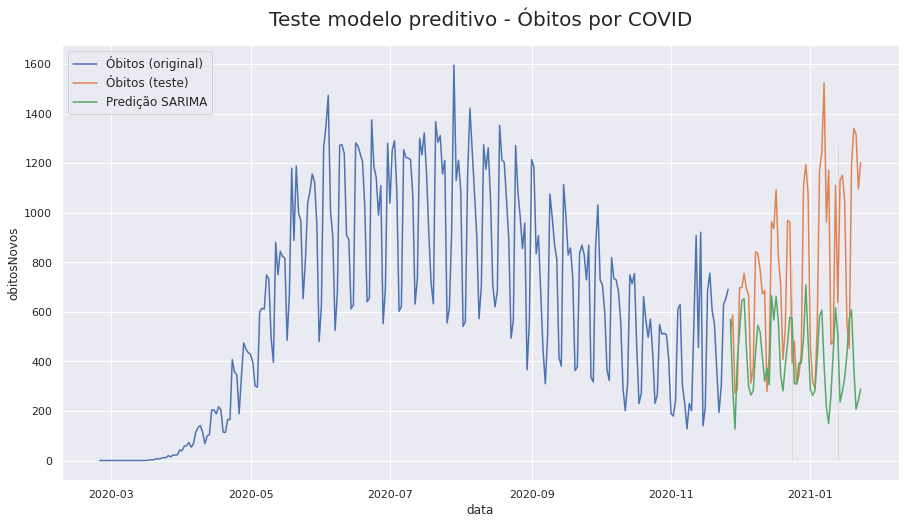

In [63]:
plt.figure(figsize=(15,8))
sns.lineplot(x='data', y='obitosNovos', data=treino_obitos)
sns.lineplot(x='data', y='obitosNovos', data=teste_obitos)
sns.lineplot(x='data', y='previsao_sarima', data=teste_obitos)
plt.title('Teste modelo preditivo - Óbitos por COVID', fontsize=20, pad=20)
plt.legend(['Óbitos (original)','Óbitos (teste)','Predição SARIMA'], fontsize=12)
plt.show()

####<p><strong><font color='#34C5F5'>Análise:</font></strong></p>
<p>As previsões para os casos e os óbitos tiveram um comportamendo parecido, no modelo SARIMA. Para puxar os parametros de sazonalidade o Colab acaba demorando bastante<p>

## Quadro comparativo entre os modelos preditivos estudados:

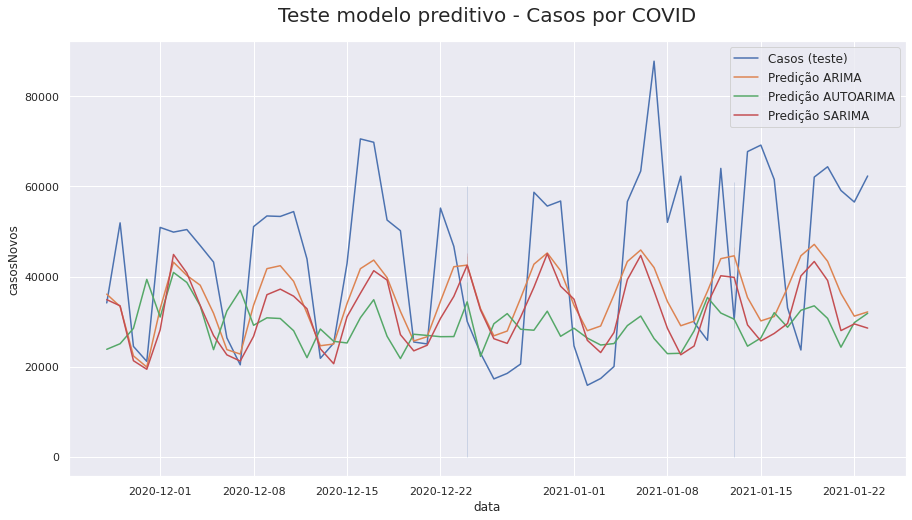

In [64]:
plt.figure(figsize=(15,8))

sns.lineplot(x='data', y='casosNovos', data=teste_casos)
sns.lineplot(x='data', y='previsao_arima', data=teste_casos)
sns.lineplot(x='data', y='previsao_autoarima', data=teste_casos)
sns.lineplot(x='data', y='previsao_sarima', data=teste_casos)
plt.title('Teste modelo preditivo - Casos por COVID', fontsize=20, pad=20)
plt.legend(['Casos (teste)','Predição ARIMA','Predição AUTOARIMA','Predição SARIMA'], fontsize=12)
plt.show()

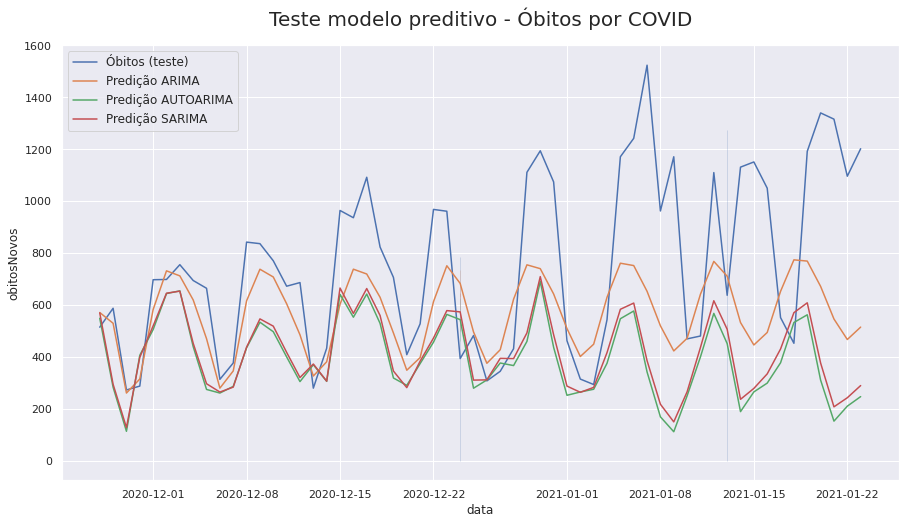

In [65]:
plt.figure(figsize=(15,8))

sns.lineplot(x='data', y='obitosNovos', data=teste_obitos)
sns.lineplot(x='data', y='previsao_arima', data=teste_obitos)
sns.lineplot(x='data', y='previsao_autoarima', data=teste_obitos)
sns.lineplot(x='data', y='previsao_sarima', data=teste_obitos)
plt.title('Teste modelo preditivo - Óbitos por COVID', fontsize=20, pad=20)
plt.legend(['Óbitos (teste)','Predição ARIMA','Predição AUTOARIMA','Predição SARIMA'], fontsize=12)
plt.show()

##<p><strong><font color='#FA8333'>Conclusão:</font></strong></p>
<p>Podemos concluir que independente do modelo, todos performaram mais o menos parecido, com um leve destaque para o modelo ARIMA.<p>
<p>Não consegui plotar previsões ainda, mas farei logo mais. Aprendi muito com esse estudo, muito legal.<p>